# Business Problem
### This project determines which tweets can be correctly identified to contain  either positive sentiments (“Positive emotion”) or negative sentiments(“Negative emotion”) using a binary classifier. 


In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

import string

from nltk.corpus import stopwords
stop = stopwords.words('english')

# 1. Obtain

In [2]:
# load in the dataset
df = pd.read_csv("emoting_tweets.csv", encoding_errors="ignore")
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


# 2. Scrub + Explore

In [3]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9063,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [4]:
df.shape

(9093, 3)

In [5]:
# rename target column
df["target"] = df["is_there_an_emotion_directed_at_a_brand_or_product"]

In [6]:
# drop former target column to clean up dataset
df.drop(columns=["is_there_an_emotion_directed_at_a_brand_or_product"], inplace=True)

In [7]:
# view target column distribution 
df["target"].value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: target, dtype: float64

In [8]:
# drop two unnecessary columns
df = df[(df["target"] != "No emotion toward brand or product") & (df["target"] != "I can't tell")]

In [9]:
# view target column distribution
df["target"].value_counts(normalize=True)

Positive emotion    0.839346
Negative emotion    0.160654
Name: target, dtype: float64

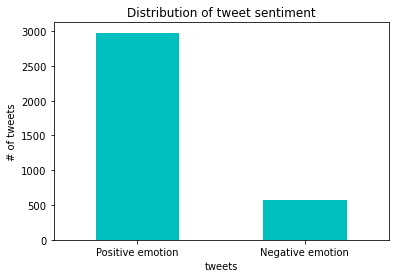

In [10]:
# View distribution of the "status_group" values
df['target'].value_counts().plot(kind='bar', color = "c")
      
# giving title to the plot
plt.title("Distribution of tweet sentiment")
      
# giving X and Y labels
plt.xlabel("tweets")
plt.xticks(rotation = 0)
plt.ylabel("# of tweets")

plt.show()

In [11]:
# view target column counts
df["target"].value_counts()

Positive emotion    2978
Negative emotion     570
Name: target, dtype: int64

In [12]:
# change "Positive emotion" to equal 1 and "Negative emotion" to equal 0
df["target"] = np.where(df['target'] == "Positive emotion", 1, 0)

In [13]:
# confirm change
df["target"].value_counts()

1    2978
0     570
Name: target, dtype: int64

In [14]:
# pd.get_dummies(df["target"], drop_first=True)

In [15]:
#df = pd.concat([df, pd.get_dummies(df['target'], drop_first=True)], axis=1)
#df.head()

In [16]:
#df["tweet_text"].astype(str)

In [17]:
#df["tweet_text"].dtypes

In [18]:
# set text to lowercase
df['tweet_lowercase'] = df['tweet_text'].map(lambda x: str(x).lower())
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,target,tweet_lowercase
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,@sxtxstate great stuff on fri #sxsw: marissa m...


In [19]:
#string.punctuation

In [20]:
# remove punctuation
no_punctuation = []
for s in df['tweet_lowercase']:
    for p in string.punctuation:
        s = s.replace(p, '')
    no_punctuation.append(s)

In [21]:
# add no_punction column to the dataframe
df['no_punctuation'] = no_punctuation

In [22]:
# view dataframe
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,target,tweet_lowercase,no_punctuation
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,wesley83 i have a 3g iphone after 3 hrs tweeti...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...,jessedee know about fludapp awesome ipadiphon...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...,swonderlin can not wait for ipad 2 also they s...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...,sxsw i hope this years festival isnt as crashy...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,@sxtxstate great stuff on fri #sxsw: marissa m...,sxtxstate great stuff on fri sxsw marissa maye...


In [23]:
# remove stop words
df['tweets_without_stopwords'] = df['no_punctuation'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [24]:
# view dataframe
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,target,tweet_lowercase,no_punctuation,tweets_without_stopwords
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,wesley83 i have a 3g iphone after 3 hrs tweeti...,wesley83 3g iphone 3 hrs tweeting riseaustin d...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...,jessedee know about fludapp awesome ipadiphon...,jessedee know fludapp awesome ipadiphone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...,swonderlin can not wait for ipad 2 also they s...,swonderlin wait ipad 2 also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...,sxsw i hope this years festival isnt as crashy...,sxsw hope years festival isnt crashy years iph...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,@sxtxstate great stuff on fri #sxsw: marissa m...,sxtxstate great stuff on fri sxsw marissa maye...,sxtxstate great stuff fri sxsw marissa mayer g...


In [25]:
# view count of most common words within tweets_without_stopwords
df['tweets_without_stopwords'].str.split(expand=True).stack().value_counts()

sxsw             3655
mention          2482
link             1310
ipad             1164
rt               1059
                 ... 
ahh                 1
wonderful           1
experimenting       1
tinkering           1
stabilizer          1
Length: 6448, dtype: int64

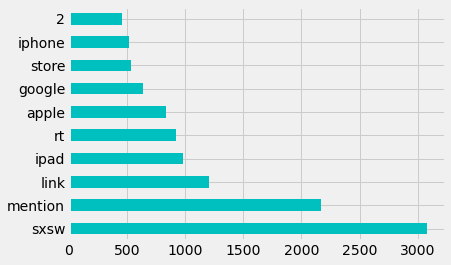

In [26]:
# most common words from "Positive emotion"
with plt.style.context('fivethirtyeight'):
    df[df['target'] == 1]['tweets_without_stopwords'].str.split(
        expand=True).stack().value_counts().head(10).plot(kind='barh', color="c")

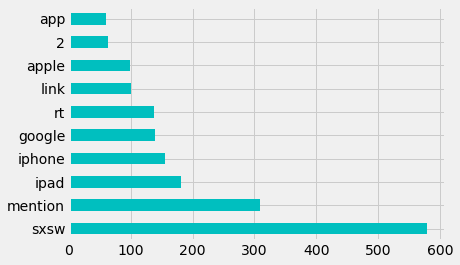

In [27]:
# most common words from "Negative emotion"
with plt.style.context('fivethirtyeight'):
    df[df['target'] == 0]['tweets_without_stopwords'].str.split(
        expand=True).stack().value_counts().head(10).plot(kind='barh', color="c")

# 4. Model

#### Train test split

In [28]:
# train test split 
X = df['tweets_without_stopwords']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

#### Bag of words

In [29]:
# bag of words 
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [30]:
lr = LogisticRegression()
lr.fit(X_train_bow, y_train)

LogisticRegression()

In [31]:
# training f1 score 
f1_score(y_train, lr.predict(X_train_bow))

0.9871908127208481

In [32]:
# testing f1 score
f1_score(y_test, lr.predict(X_test_bow))

0.9241645244215938

In [33]:
dt = DecisionTreeClassifier()
dt.fit(X_train_bow, y_train)

# training accuracy 
f1_score(y_train, dt.predict(X_train_bow))

1.0

In [34]:
# testing accuracy 
f1_score(y_test, dt.predict(X_test_bow))

0.902166776099803

In [35]:
dt = DecisionTreeClassifier(max_depth = 70)
dt.fit(X_train_bow, y_train)

# training accuracy 
f1_score(y_train, dt.predict(X_train_bow))

0.9883028029132642

In [36]:
# testing accuracy 
f1_score(y_test, dt.predict(X_test_bow))

0.9079118028534372

In [37]:
rf = RandomForestClassifier()

rf.fit(X_train_bow, y_train)

# training accuracy 
f1_score(y_train, rf.predict(X_train_bow))

1.0

In [38]:
# testing accuracy 
f1_score(y_test, rf.predict(X_test_bow))

0.9261829652996846

In [39]:
rf50 = RandomForestClassifier(max_depth=50)

rf50.fit(X_train_bow, y_train)

# training accuracy 
print(f1_score(y_train, rf50.predict(X_train_bow)))
# testing accuracy
print(f1_score(y_test, rf50.predict(X_test_bow)))

0.9393748688902873
0.9167701863354036


### Try models with balanced class weight 

In [40]:
lr_cw = LogisticRegression(class_weight='balanced')
lr_cw.fit(X_train_bow, y_train)

LogisticRegression(class_weight='balanced')

In [41]:
# training f1 score
f1_score(y_train, lr_cw.predict(X_train_bow))


0.9934816812766915

In [42]:
f1_score(y_test, lr_cw.predict(X_test_bow))

0.9069925322471146

In [43]:
## decision tree, random forest (class_weight="balanced")

In [44]:
# decision tree classifier, class_weight("balanced")
dt = DecisionTreeClassifier(class_weight="balanced")
dt.fit(X_train_bow, y_train)

# training accuracy 
f1_score(y_train, dt.predict(X_train_bow))

1.0

In [45]:
# testing accuracy 
f1_score(y_test, dt.predict(X_test_bow))

0.8663853727144866

In [46]:
# random forest classifier, class_weight("balanced")
rfcwb = RandomForestClassifier(class_weight="balanced")

rfcwb.fit(X_train_bow, y_train)

# training accuracy 
f1_score(y_train, rfcwb.predict(X_train_bow))

0.9997767358785443

In [47]:
f1_score(y_test, rfcwb.predict(X_test_bow))

0.9255050505050505

#### TFIDF

In [48]:
# tfidf 
tfidf_vectorizer = TfidfVectorizer()
X_train_tf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = tfidf_vectorizer.transform(X_test)

In [49]:
lr = LogisticRegression()
lr.fit(X_train_tf, y_train)

print(f"training score")
print(lr.score(X_train_tf, y_train))
print(f"test score")
print(lr.score(X_test_tf, y_test))

training score
0.8628335212326194
test score
0.8432919954904171


In [50]:
lr.score(X_test_tf, y_test)

0.8432919954904171

In [51]:
dt = DecisionTreeClassifier(max_depth=75)
dt.fit(X_train_tf, y_train)

# training accuracy 
dt.score(X_train_tf, y_train)


print(f"training score")
print(dt.score(X_train_tf, y_train))
print(f"test score")
print(dt.score(X_test_tf, y_test))

training score
0.9902292371288989
test score
0.8173618940248027


In [52]:
rf50_tfidf= RandomForestClassifier(max_depth=50)

rf50_tfidf.fit(X_train_tf, y_train)

# training accuracy 
print(rf50_tfidf.score(X_train_tf, y_train))
# testing accuracy
print(rf50_tfidf.score(X_test_tf, y_test))

0.8917700112739572
0.8421645997745209


In [53]:
### lr, dt, rf class_weight=balanced on tfidf data

In [54]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train_tf, y_train)

print(f"training score")
print(lr.score(X_train_tf, y_train))
print(f"test score")
print(lr.score(X_test_tf, y_test))

training score
0.9492671927846674
test score
0.8331454340473506


In [55]:
dt = DecisionTreeClassifier(max_depth=75, class_weight="balanced")
dt.fit(X_train_tf, y_train)

# training accuracy 
dt.score(X_train_tf, y_train)


print(f"training score")
print(dt.score(X_train_tf, y_train))
print(f"test score")
print(dt.score(X_test_tf, y_test))

training score
0.9229612927470876
test score
0.7733934611048479


In [56]:
rf50_cwb_tfidf = RandomForestClassifier(max_depth=50, class_weight="balanced")

rf50_cwb_tfidf.fit(X_train_tf, y_train)

print(f"training score")
print(rf50_cwb_tfidf.score(X_train_tf, y_train))
print(f"test score")
print(rf50_cwb_tfidf.score(X_test_tf, y_test))

training score
0.9815858699736941
test score
0.85456595264938


# 5. Interpret

C:\Users\Jeff\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


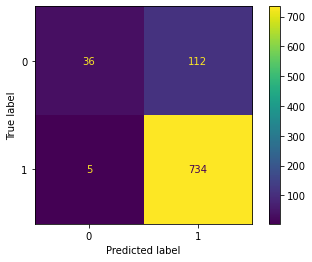

In [62]:
plot_confusion_matrix(rf, X_test_bow, y_test)

In [63]:
rf.feature_importances_

array([0.00000000e+00, 2.50994255e-07, 2.78975865e-04, ...,
       0.00000000e+00, 3.73638766e-04, 1.93346765e-06])

In [65]:
vectorizer.get_feature_names_out()

array(['0310', '0310apple', '10', ..., 'zoom', 'zzzs', 'ξсԍύݍ'],
      dtype=object)

In [102]:
feat_importance = pd.DataFrame({"word": vectorizer.get_feature_names_out(), 
                               "importance": rf.feature_importances_})

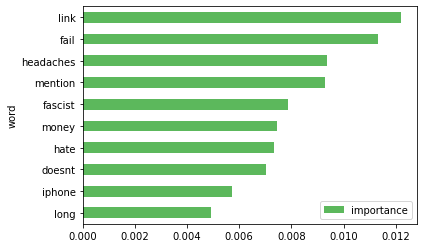

In [114]:
color=['#5cb85c','#5bc0de','#d9534f']
feat_importance.sort_values(by="importance", ascending=False).head(10).set_index("word").plot(kind="barh", color=color)
plt.gca().invert_yaxis()

In [117]:
fi = feat_importance.sort_values(by="importance", ascending=False).head(10)
fi

,word,importance
2812,link,0.012211
1722,fail,0.011311
2218,headaches,0.009377
3024,mention,0.009289
1745,fascist,0.007875
3113,money,0.007461
2207,hate,0.007321
1425,doesnt,0.007009
2547,iphone,0.005729
2853,long,0.004918


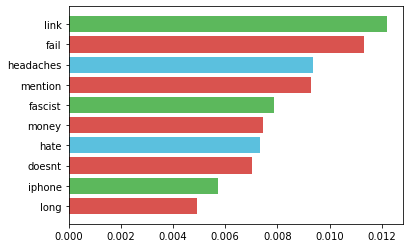

In [124]:
plt.barh(y=fi["word"], width=fi["importance"], color=['#5cb85c', '#d9534f','#5bc0de','#d9534f'])
plt.gca().invert_yaxis()

In [77]:
def word_counts_by_class(word):
    try:
        positive = df[df['target'] == 1]['tweets_without_stopwords'].str.split(expand=True).stack().value_counts()[word]
    except KeyError:
        positive = 0
    try:
        negative =   df[df['target'] == 0]['tweets_without_stopwords'].str.split(expand=True).stack().value_counts()[word]
    except KeyError:
        negative = 0
    print(f"postive count: {positive}")
    print(f"negative count: {negative}")

In [123]:
word_counts_by_class("fail")

postive count: 7
negative count: 17


In [87]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,target,tweet_lowercase,no_punctuation,tweets_without_stopwords
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,wesley83 i have a 3g iphone after 3 hrs tweeti...,wesley83 3g iphone 3 hrs tweeting riseaustin d...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...,jessedee know about fludapp awesome ipadiphon...,jessedee know fludapp awesome ipadiphone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...,swonderlin can not wait for ipad 2 also they s...,swonderlin wait ipad 2 also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...,sxsw i hope this years festival isnt as crashy...,sxsw hope years festival isnt crashy years iph...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,@sxtxstate great stuff on fri #sxsw: marissa m...,sxtxstate great stuff on fri sxsw marissa maye...,sxtxstate great stuff fri sxsw marissa mayer g...


In [92]:
def tweet_finder_by_word(word):
    for index, row in df.iterrows():
        if word in row["tweets_without_stopwords"]:
            if row["target"] == 0:
                print(f"negative - {row['tweet_text']}")
            else:
                print(f"positive - {row['tweet_text']}")

In [100]:
tweet_finder_by_word("fail")

positive - Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1.   #fail
positive - I love my @mention iPhone case from #Sxsw but I can't get my phone out of it #fail
positive - How could I forget my cell phone today for #SXSW what a fail glad I have my iPad #lifelinetotheworld
negative - So we get to see google fail at social on another day RT @mention Okay, no Google Circles debuting at #sxsw today
negative - @mention @mention @mention @mention Paper phones?  Means an iPad will likely be useless at #sxsw as well. #fail
negative - 2+ hour wait at the makeshift Apple store for iPad 2. #fail #sxsw
negative - @mention another google social failure? #sxsw
negative - Stupid technology! You always fail at important times! At #SXSW w/ an iPhone, laptop AND Blackberry and the only thing working is my pen.
positive - Fail Whale artist @mention living through the iPad 2 #sxsw {link}
negative - #sxsw live stream not working on iPad #fail {

In [ ]:
with plt.style.context('fivethirtyeight'):
    df[df['target'] == 1]['tweets_without_stopwords'].str.split(
        expand=True).stack().value_counts().head(10).plot(kind='barh', color="c")

In [58]:
# 1/ Use F1 score instead of accuracy for ALL THE MODELS. Harmonic mean of precision and recall
# 2. For each model, try setting class weight (class_weight="balanced")

In [ ]:
positive - Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1.   #fail

# Future work, look at the labels of the tweets. There looks to be examples of tweets that seem to be mislabeled, such as 